In [33]:
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset


# Questions

- Which intervalls to use?
	- Convert electricity to h/w/m?


possible conversion:
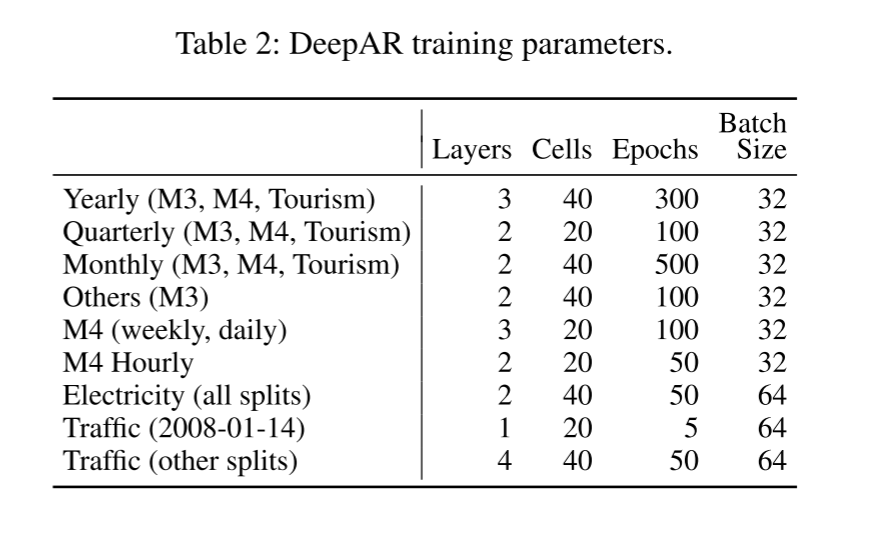


dataset statistics:
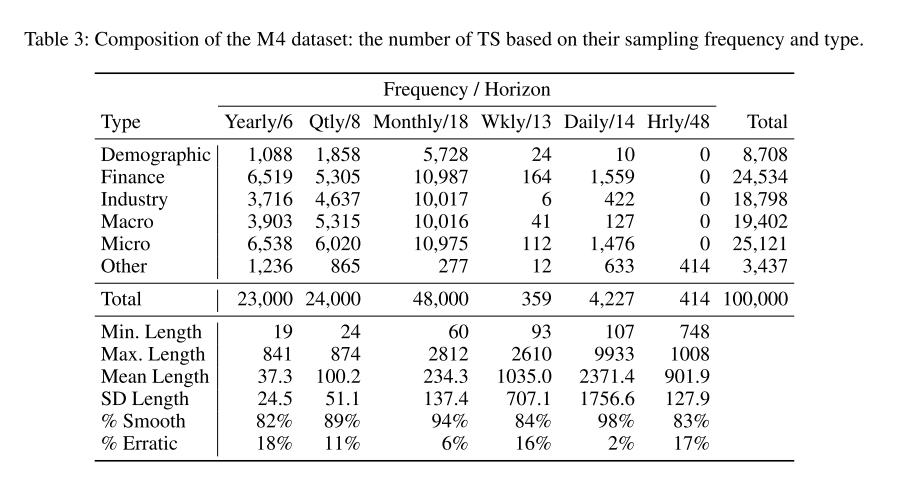

how to split electricity dataset:

Flunkert, V.; Salinas, D.; and Gasthaus, J. 2017. DeepAR: Proba-
bilistic Forecasting with Autoregressive Recurrent Networks. CoRR
abs/1704.04110.

	"For electricity we train with data between 2014-01-01 and 2014-09-
	01"
	"The results for electricity and
	traffic are computed using rolling window predictions done after the last point seen in training as
	described in [23]. We do not retrain our model for each window, but use a single model trained on
	the data before the first prediction window."


Hsiang-Fu Yu, Nikhil Rao, and Inderjit S Dhillon. Temporal regularized matrix factorization
for high-dimensional time series prediction. In D. D. Lee, M. Sugiyama, U. V. Luxburg,
I. Guyon, and R. Garnett, editors, Advances in Neural Information Processing Systems 29,
pages 847–855. Curran Associates, Inc., 2016.

	"input 7 days, predict 24h ahead" - no rolling window mentioned 

In [ ]:
data_dict = {
    'ETTh1': Dataset_ETT_hour,
    'ETTh2': Dataset_ETT_hour,
    'ETTm1': Dataset_ETT_minute,
    'ETTm2': Dataset_ETT_minute,
    'Solar': Dataset_Solar,
    'PEMS': Dataset_PEMS,
    'custom': Dataset_Custom,
}

In [146]:
class SlidingWindowTimeSeriesDataset(Dataset):
	def __init__(self, window_size, pred_length, train:bool=False, test:bool=False):
		self.file_path = "abc" # TODO read from config
		self.train_data = None
		self.val_data = None
		self.test_data = None
		self.train_tensor = None
		self.val_tensor = None
		self.test_tensor = None
		self.train = train
		self.test = test

		self.window_size = window_size
		self.pred_length = pred_length
		self.total_seq_size = self.window_size + self.pred_length


	def load_electricity(self):
		"""
		-load from .txt file, resample from 15min to 1h intervalls
		-fill NANs inbetween and drop outside of range
		-remove time
		
		"""
		df = pd.read_csv("/home/ben_ten/ben/MA/datasets/electricity/LD2011_2014.txt", index_col=0, sep=';', decimal=',')
		df.index = pd.to_datetime(df.index)
		df.sort_index(inplace=True)

		# Used to determine the start and end dates of a series
		output = df.resample('1h').mean().replace(0., np.nan)
		earliest_time = output.index.min()

		df_list = []
		for label in output:
			srs = output[label]

			start_date = min(srs.fillna(method='ffill').dropna().index)
			end_date = max(srs.fillna(method='bfill').dropna().index)

			active_range = (srs.index >= start_date) & (srs.index <= end_date)
			srs = srs[active_range].fillna(0.)

			tmp = pd.DataFrame({'target': srs})
			date = tmp.index
			tmp['date'] = date
			tmp['id'] = label

			df_list.append(tmp)

		output = pd.concat(df_list, axis=0, join='outer').reset_index(drop=True)
		output = output[(output['date'] >= "2014-01-01")]

		# calc max length and only keep ids that have the same
		# TODO explain in paper why drop instead of backfill
		# rather less timeseries but real world data than synthetic data
		# refference paper with dropped

		id_counts = output.groupby('id')['date'].count()
		max_timestep_count = id_counts.max()
		ids_with_max_count = id_counts[id_counts == max_timestep_count].index

		# Filter the original DataFrame to keep only the desired ids
		output = output[output['id'].isin(ids_with_max_count)]

		# TODO assigbnment in extra function
		if self.train == True:
			output_train = output[(output['date'] >= "2014-01-01") & (output["date"] <= "2014-08-23")].copy() # cutoff taken from previous papers
			output_val = output[(output['date'] > "2014-08-23") & (output["date"] < "2014-09-01")].copy() 
			
			output_train.reset_index(drop=True, inplace=True)
			output_val.reset_index(drop=True, inplace=True)

			self.train_data = output_train
			self.val_data = output_val

		if self.test == True:
			output_test = output[(output['date'] >= "2014-09-01")].copy() # cutoff taken from previous papers
			output_test.reset_index(drop=True, inplace=True)
			self.test_data = output_test

	def load_euro_electricity(self):
		df = pd.read_csv("/home/ben_ten/ben/MA/datasets/electricity_europe/time_series_60min_singleindex.csv")
		
		columns_to_delete = ['forecast']
		df = df.drop([col for col in df.columns if any(partial_name in col for partial_name in columns_to_delete)], axis=1)

		# drop columns with more than 40% missing values
		threshold = 0.3 * len(df)
		columns_to_drop = df.columns[df.isna().sum() > threshold]
		df = df.drop(columns=columns_to_drop)

		# drop rows with more than 10% NANs
		threshold = 0.05 * len(df.columns)
		df = df[df.isna().sum(axis=1) <= threshold]

		# forward fill if previous values are present
		df = df.fillna(method='ffill')

		# values at the start are set to zero, no more NANs
		df = df.fillna(0)
		

	def _df_to_tensor(self, df):
		"""
		helpfer_function
		"""
		df.sort_values(by=['id', 'date'], inplace=True)
		# check what noral length is
		max_len = df.groupby("id").count()["target"].max()

		# Initialize a list to store tensors
		tensors = []

		# Unique IDs
		unique_ids = df['id'].unique()

		# For each 'id', create a tensor and add it to the list
		for unique_id in unique_ids:
			# Filter rows by 'id'
			df_id = df[df['id'] == unique_id]
			# Select relevant columns and convert to tensor
			tensor = torch.tensor(df_id['target'].values, dtype=torch.float32)
			# Add tensor to list if it is not too short
			if len(tensor) == max_len:
				tensors.append(tensor)

		# Concatenate all tensors along a new dimension, transpose
		result_tensor = torch.stack(tensors)
		return result_tensor.transpose(0,1)


	def create_tensor_from_df(self):
		"""
		logic for which tensor to return
		"""
		if self.train == True:
			self.train_tensor = self._df_to_tensor(self.train_data)
			self.val_tensor = self._df_to_tensor(self.val_data)
		if self.test == True:
			self.test_tensor = self._df_to_tensor(self.test_data)


	def __len__(self):
		# count each individual window for each id
		return self.data.shape[0] * (self.data.shape[1] - self.total_seq_size + 1)

	def __getitem__(self, index):
		# calculate which id and time step to use based on the index
		num_windows_per_id = self.data.shape[1] - self.total_seq_size + 1
		id_index = index // num_windows_per_id
		time_index = index % num_windows_per_id

		# Extract the window for the current id and time step
		window = self.data[id_index, time_index:time_index+self.window_size, :]
		target = self.data[id_index, time_index+self.window_size:time_index+self.total_seq_size, :]	
		return window, target

In [147]:
instance = SlidingWindowTimeSeriesDataset(132, 24, train=True)
instance.load_electricity()
instance.create_tensor_from_df()
df = instance.tensor
df.shape

torch.Size([5617, 348])

In [148]:
instance = SlidingWindowTimeSeriesDataset(132, 24, test=True)
instance.load_electricity()
instance.create_tensor_from_df()
df = instance.tensor
df.shape

torch.Size([2929, 348])

In [114]:
		# load data from self.file_path
		df = pd.read_csv("/home/ben_ten/ben/MA/datasets/electricity/LD2011_2014.txt", index_col=0, sep=';', decimal=',')
		df.index = pd.to_datetime(df.index)
		df.sort_index(inplace=True)

		# Used to determine the start and end dates of a series
		output = df.resample('1h').mean().replace(0., np.nan)
		earliest_time = output.index.min()

		df_list = []
		for label in output:
			srs = output[label]

			start_date = min(srs.fillna(method='ffill').dropna().index)
			end_date = max(srs.fillna(method='bfill').dropna().index)

			active_range = (srs.index >= start_date) & (srs.index <= end_date)
			srs = srs[active_range].fillna(0.)

			tmp = pd.DataFrame({'target': srs})
			date = tmp.index
			tmp['date'] = date
			tmp['id'] = label

			df_list.append(tmp)

		output = pd.concat(df_list, axis=0, join='outer').reset_index(drop=True)

In [145]:
output_train = output[output['date'] >= "2014-01-01"]

# Group by 'id' and count once
id_counts = output_train.groupby('id')['date'].count()

# Calculate the maximum timestep count
max_timestep_count = id_counts.max()

# Get the IDs with the maximum timestep count
ids_with_max_count = id_counts[id_counts == max_timestep_count].index

# Filter the original DataFrame to keep only the desired IDs
result_df = output_train[output_train['id'].isin(ids_with_max_count)]

MT_001    8761
MT_249    8761
MT_257    8761
MT_256    8761
MT_255    8761
          ... 
MT_129    8761
MT_128    8761
MT_127    8761
MT_126    8761
MT_370    8761
Name: id, Length: 348, dtype: int64

In [141]:
max_timestep_count = 35000

35065

In [133]:
max_timesteps_per_id = output.groupby('id')['date'].max()

# Find the maximum of these maximums
max_max_timesteps = max_timesteps_per_id.max()

# Filter the DataFrame to keep only rows with IDs having the same maximum number of timesteps
filtered_df = output[output.groupby('id')['date'].transform('max') == max_max_timesteps]
filtered_df["id"].value_counts()

MT_163    35065
MT_218    35065
MT_227    35065
MT_226    35065
MT_225    35065
          ...  
MT_109     7609
MT_116     7609
MT_181     7249
MT_133     7041
MT_178     4009
Name: id, Length: 367, dtype: int64

In [131]:
filtered_df["id"].value_counts()

MT_163    35065
MT_218    35065
MT_227    35065
MT_226    35065
MT_225    35065
          ...  
MT_109     7609
MT_116     7609
MT_181     7249
MT_133     7041
MT_178     4009
Name: id, Length: 367, dtype: int64

In [119]:
var = 35065

# Pre process including covariates

In [ ]:
# execute this to fully prep 1 batch electricity for iTrasnfromer 

def split_data(df, valid_boundary=1315, test_boundary=1339, use_scaler=True):
	index = df['days_from_start']
	train = df.loc[index < valid_boundary]
	valid = df.loc[(index >= valid_boundary - 7) & (index < test_boundary)]
	test = df.loc[index >= test_boundary - 7]

	if use_scaler == True:
		electricity_scaler = StandardScaler()
	
		variates =  ['power_usage', 'time_idx', 'days_from_start', 'hour', 'day', 'day_of_week', 'month']
		electricity_scaler.fit(train[variates])
		train[variates] = electricity_scaler.transform(train[variates])
		test[variates] = electricity_scaler.transform(test[variates])
		valid[variates] = electricity_scaler.transform(valid[variates])

		electricity_dict = {
						"train" : train,
						"test" : test,
						"valid" : valid,
						"scaler" : electricity_scaler
						}
	else:
		electricity_dict = {
						"train" : train,
						"test" : test,
						"valid" : valid,
						}
	return electricity_dict

def df_to_tensor(df):
	df.sort_values(by=['id', 'time_idx'], inplace=True)

	# Initialize a list to store tensors
	tensors = []

	# Unique IDs
	unique_ids = df['id'].unique()

	# For each 'id', create a tensor and add it to the list
	for unique_id in unique_ids:
		# Filter rows by 'id'
		df_id = df[df['id'] == unique_id]    
		# Select relevant columns and convert to tensor
		tensor = torch.tensor(df_id[['power_usage', 'hour', 'day', 'day_of_week', 'month']].values, dtype=torch.float32)
		# Add tensor to list
		tensors.append(tensor)

	# Concatenate all tensors along a new dimension
	result_tensor = torch.stack(tensors)
	return result_tensor



df = pd.read_csv('datasets/electricity/electricity_small.csv')
electricity = split_data(df, use_scaler=True)

train_tensor = df_to_tensor(electricity["train"])
valid_tensor = df_to_tensor(electricity["valid"])
test_tensor = df_to_tensor(electricity["test"])

# Preprocess without covariates

In [3]:
import pandas as pd
m4_hourly = pd.read_csv("/home/ben_ten/ben/MA/datasets/m4/Hourly-train.csv")


/home/ben_ten/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
m4_hourly

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V952,V953,V954,V955,V956,V957,V958,V959,V960,V961
0,H1,605.0,586.0,586.0,559.0,511.0,443.0,422.0,395.0,382.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H2,3124.0,2990.0,2862.0,2809.0,2544.0,2201.0,1996.0,1861.0,1735.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H3,1828.0,1806.0,1897.0,1750.0,1679.0,1620.0,1463.0,1342.0,1192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H4,6454.0,6324.0,6075.0,5949.0,5858.0,5579.0,5163.0,4790.0,4478.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H5,4263.0,4297.0,4236.0,4080.0,3883.0,3672.0,3248.0,2841.0,2513.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,H410,153.0,196.0,163.0,131.0,82.0,53.0,57.0,54.0,46.0,...,132.0,165.0,191.0,186.0,119.0,108.0,70.0,72.0,79.0,77.0
410,H411,24.0,30.0,22.0,14.0,19.0,20.0,24.0,45.0,38.0,...,122.0,195.0,166.0,154.0,132.0,76.0,66.0,67.0,51.0,42.0
411,H412,19.0,30.0,12.0,16.0,13.0,15.0,15.0,21.0,21.0,...,111.0,166.0,225.0,278.0,144.0,71.0,70.0,73.0,39.0,36.0
412,H413,21.0,16.0,17.0,19.0,16.0,22.0,21.0,15.0,23.0,...,77.0,91.0,76.0,68.0,68.0,59.0,58.0,53.0,38.0,46.0
